# Employee Productivity Prediction Using Tree Models

## Load Data

In [81]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/garments_worker_productivity.csv', parse_dates=['date'])

## Examine

In [82]:
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,2015-01-01,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,2015-01-01,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,2015-01-01,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1197 non-null   datetime64[ns]
 1   quarter                1197 non-null   object        
 2   department             1197 non-null   object        
 3   day                    1197 non-null   object        
 4   team                   1197 non-null   int64         
 5   targeted_productivity  1197 non-null   float64       
 6   smv                    1197 non-null   float64       
 7   wip                    691 non-null    float64       
 8   over_time              1197 non-null   int64         
 9   incentive              1197 non-null   int64         
 10  idle_time              1197 non-null   float64       
 11  idle_men               1197 non-null   int64         
 12  no_of_style_change     1197 non-null   int64         
 13  no_

### Column Descriptions

date: date in MM-DD-YYYY

quarter: a portion of the month — month was divided into four quarters

department: associated department with the instance

day: day of the week

team: associated team number with the instance

targeted_productivity: targeted productivity set by the authority for each team for each day

smv: standard minute value — the allocated time for a task

wip: work in progress — includes the number of unfinished items for products

over_time: represents the amount of overtime by each team in minutes

incentive: represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action

idle_time: the duration of time when the production was interrupted due to several reasons

idle_men: the number of workers who were idle due to production interruption

no_of_style_change: number of changes in the style of a particular product

no_of_workers: number of workers on each team

actual_productivity: the actual % of productivity that was delivered by the workers — it ranges from 0 to 1.

In [84]:
df.shape

(1197, 15)

### Check Nulls

In [85]:
df.isnull().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

### Check Categorical Column Value Counts

In [86]:
cols = ['quarter', 'department', 'day', 'team']

for col in cols:
    print(f'{df[col].value_counts()}\n')

quarter
Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: count, dtype: int64

department
sweing        691
finishing     257
finishing     249
Name: count, dtype: int64

day
Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: count, dtype: int64

team
8     109
2     109
4     105
1     105
9     104
10    100
12     99
7      96
3      95
6      94
5      93
11     88
Name: count, dtype: int64



### Quick Findings:

#### `quarter`:

- 5th quarter exists.

#### `department`:

- Typo in "sweing"
- Two "finishing" values, perhaps whitespace

#### `day`:

- All days except "Friday", perhaps no production on Fridays

#### `team`:

- 12 total teams

### Comparing Related Columns

In [87]:
df[['targeted_productivity', 'actual_productivity']].describe()

,targeted_productivity,actual_productivity
count,1197.000000,1197.000000
mean,0.729632,0.735091
std,0.097891,0.174488
min,0.070000,0.233705
25%,0.700000,0.650307
50%,0.750000,0.773333
75%,0.800000,0.850253
max,0.800000,1.120437


We can see some abnormal values, specifically within `actual_productivity`. The max value seems to be above the possible productivity value (a scale from 0-100%), as it is observed as 1.12 (112%) productivity. Let's check this column's unique values.

In [88]:
df.loc[df['actual_productivity'] > 1, 'actual_productivity'].value_counts(dropna=False).sort_index(ascending=False)

actual_productivity
1.120437     1
1.108125     1
1.100484     1
1.096633     1
1.059621     1
1.057963     1
1.050667     1
1.050281     1
1.033570     1
1.033156     1
1.020000     1
1.011562     1
1.004889     1
1.001417     1
1.000671     1
1.000602     1
1.000457     1
1.000446     1
1.000402     1
1.000345     2
1.000230    11
1.000066     1
1.000019     4
Name: count, dtype: int64

In [89]:
print('Observations Where Actual Productivity > 1: ',df.loc[df['actual_productivity'] > 1, 'actual_productivity'].count())
print('Total Observations ', df.shape[0])
print('Proportion: ', round(df.loc[df['actual_productivity'] > 1, 'actual_productivity'].count() / df.shape[0], 2))

Observations Where Actual Productivity > 1:  37
Total Observations  1197
Proportion:  0.03


We could deal with this problem a couple of ways. 

We could: 

- Scale the data
- Replace the values with 1.0 as they effectively max out the scale

As these abnormalities seem to only occur on a small fraction of our overall observations, we will simply replace the values with the maximum of our scale, in order to avoid altering the scaling between `target_productivity` as well. We could have also scaled `target_productivity` to the same scaling, but this method is quicker as there are only a few problematic observations.

We'll clean this in the next section.

## Cleaning

### `actual_productivity`

We'll simply cap off our abnormal values to max out at 1.0.

In [90]:
df.loc[df['actual_productivity'] > 1, 'actual_productivity'] = 1

In [91]:
df[['targeted_productivity', 'actual_productivity']].describe()

,targeted_productivity,actual_productivity
count,1197.000000,1197.000000
mean,0.729632,0.734461
std,0.097891,0.173380
min,0.070000,0.233705
25%,0.700000,0.650307
50%,0.750000,0.773333
75%,0.800000,0.850253
max,0.800000,1.000000


### `wip` and `department` columns

In [92]:
df['wip'].value_counts(dropna=False).sort_values(ascending=False)

wip
NaN       506
1039.0      5
1282.0      4
1108.0      3
1138.0      3
         ... 
1674.0      1
290.0       1
971.0       1
992.0       1
984.0       1
Name: count, Length: 549, dtype: int64

In [93]:
df[df['wip'].isnull()].sample(5)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
394,2015-01-24,Quarter4,finishing,Saturday,10,0.75,3.94,NaN,1800,0,0.0,0,0,10.0,0.937242
1194,2015-03-11,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
125,2015-01-07,Quarter1,finishing,Wednesday,5,0.70,4.15,NaN,1440,0,0.0,0,0,8.0,0.330114
715,2015-02-11,Quarter2,finishing,Wednesday,8,0.35,4.15,NaN,1440,0,0.0,0,0,12.0,0.994375
823,2015-02-18,Quarter3,finishing,Wednesday,12,0.80,5.13,NaN,1200,0,0.0,0,0,10.0,0.991800


We will drill down into cases surrounding null values. Perhaps null `wip` entries are due to preceding or upcoming weeks.

In [94]:
df.iloc[309:322]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
309,2015-01-18,Quarter3,sweing,Sunday,12,0.80,26.87,585.0,5670,56,0.0,0,0,31.5,0.662256
310,2015-01-18,Quarter3,sweing,Sunday,3,0.65,22.52,1138.0,10170,35,0.0,0,0,56.5,0.650417
311,2015-01-18,Quarter3,sweing,Sunday,11,0.65,14.89,1140.0,10260,44,0.0,0,0,57.0,0.650300
312,2015-01-18,Quarter3,sweing,Sunday,2,0.65,22.94,1025.0,10170,26,0.0,0,0,56.5,0.650243
313,2015-01-18,Quarter3,finishing,Sunday,8,0.80,2.90,NaN,1440,0,0.0,0,0,8.0,0.639867
314,2015-01-18,Quarter3,sweing,Sunday,5,0.60,20.40,1031.0,10440,30,0.0,0,0,58.0,0.600063
315,2015-01-18,Quarter3,finishing,Sunday,9,0.80,3.94,NaN,1800,0,0.0,0,0,10.0,0.582045
316,2015-01-18,Quarter3,sweing,Sunday,1,0.80,49.10,1381.0,10350,24,0.0,0,0,57.5,0.403242
317,2015-01-18,Quarter3,finishing,Sunday,10,0.70,3.94,NaN,1440,0,0.0,0,0,8.0,0.235795
318,2015-01-19,Quarter3,finishing,Monday,4,0.70,4.30,NaN,5040,0,0.0,0,0,28.0,0.977273


Seeing this specific slice of our data, we can identify an interesting pattern. The cases in which `wip` is missing all occur in the finishing department. Lets see what other entries the finishing department in particular contains in comparison to the rest. Also we need to clean `department` anyways, due to two existing "finishing" values.

In [95]:
df['department'].unique().tolist()

['sweing', 'finishing ', 'finishing']

We can see that our earlier theory was correct—there is whitespace proceeding one of the values. We will correct this.

In [96]:
df['department'] = df['department'].replace('finishing ', 'finishing')

We will also correct the type on "sewing"

In [97]:
df['department'] = df['department'].replace('sweing', 'sewing')

In [98]:
df['department'].unique().tolist()

['sewing', 'finishing']

Now we can check for null `wip` values by `department`

In [99]:
df.loc[df['department'] == 'sewing', 'wip'].isnull().sum()

np.int64(0)

In [100]:
df.loc[df['department'] == 'finishing', 'wip'].isnull().sum()

np.int64(506)

Interesting. Let's see the total amount of entries for the `finishing` department.

In [101]:
df.loc[df['department'] == 'finishing', 'wip'].shape

(506,)

We can now see that every entry for the `wip` column within the `finishing` department is missing.

This is most likely due to `finishing` leaving no works-in-progress, so we can effectively set these instances to 0.

In [102]:
df['wip'] = df['wip'].fillna(0)

In [103]:
df.isnull().sum()

date                     0
quarter                  0
department               0
day                      0
team                     0
targeted_productivity    0
smv                      0
wip                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
no_of_workers            0
actual_productivity      0
dtype: int64

### `quarter` column

For this column we will simply alter the "Quarter5" entries to "Quarter4".

In [104]:
df['quarter'] = df['quarter'].replace('Quarter5', 'Quarter4')

In [105]:
df['quarter'].value_counts()

quarter
Quarter1    360
Quarter2    335
Quarter4    292
Quarter3    210
Name: count, dtype: int64

## Re-examine After Cleaning

In [106]:
df.columns

Index(['date', 'quarter', 'department', 'day', 'team', 'targeted_productivity',
       'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men',
       'no_of_style_change', 'no_of_workers', 'actual_productivity'],
      dtype='object')

In [107]:
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sewing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,0.886500
2,2015-01-01,Quarter1,sewing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,2015-01-01,Quarter1,sewing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,2015-01-01,Quarter1,sewing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [108]:
df.describe(include='all')

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197,1197,1197,1197,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
unique,NaN,4,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Quarter1,sewing,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,360,691,208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2015-02-04 10:56:50.526315776,NaN,NaN,NaN,6.426901,0.729632,15.062172,687.228070,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.734461
min,2015-01-01 00:00:00,NaN,NaN,NaN,1.000000,0.070000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,2015-01-18 00:00:00,NaN,NaN,NaN,3.000000,0.700000,3.940000,0.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,2015-02-03 00:00:00,NaN,NaN,NaN,6.000000,0.750000,15.260000,586.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,2015-02-23 00:00:00,NaN,NaN,NaN,9.000000,0.800000,24.260000,1083.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,2015-03-11 00:00:00,NaN,NaN,NaN,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.000000


We will drop the `date` column as this is effectively dealt with using `quarter` and `day`. Also, we can see that our data spans only 3 months, so the `date` column does not really offer much extra data.

We *could* feature-engineer a `month` column. However, fitting with only 3 months of data could potentially negatively effect our results, especially if we wanted to predict on any other months.

### Drop `date`

In [109]:
df.drop(columns=['date'], inplace=True)

## Prepare Column Types (`quarter`, `day`)

We need to convert these columns to integer types in order to build our model.

### Check Current Unique Values

In [110]:
df['quarter'].unique()

array(['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4'], dtype=object)

In [111]:
df['day'].unique()

array(['Thursday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday'],
      dtype=object)

### Map to New Values

In [112]:
df['quarter'] = df['quarter'].map({'Quarter1': 1, 'Quarter2': 2, 'Quarter3': 3, 'Quarter4': 4})

df['day'] = df['day'].map({'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7})

In [113]:
df['quarter'].unique()

array([1, 2, 3, 4])

In [114]:
df['day'].unique()

array([5, 7, 1, 2, 3, 4])

In [115]:
df.dtypes

quarter                    int64
department                object
day                        int64
team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
dtype: object

Great! Now we just need to encode `department`.

## Encoding `department`

In [116]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

col_trans = make_column_transformer(
    (OneHotEncoder(), ['department']),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [117]:
onehot_df = col_trans.fit_transform(df)

In [118]:
df = pd.DataFrame(onehot_df, columns=col_trans.get_feature_names_out())

In [119]:
df.head()

,department_finishing,department_sewing,quarter,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,0.0,1.0,1.0,5.0,8.0,0.80,26.16,1108.0,7080.0,98.0,0.0,0.0,0.0,59.0,0.940725
1,1.0,0.0,1.0,5.0,1.0,0.75,3.94,0.0,960.0,0.0,0.0,0.0,0.0,8.0,0.886500
2,0.0,1.0,1.0,5.0,11.0,0.80,11.41,968.0,3660.0,50.0,0.0,0.0,0.0,30.5,0.800570
3,0.0,1.0,1.0,5.0,12.0,0.80,11.41,968.0,3660.0,50.0,0.0,0.0,0.0,30.5,0.800570
4,0.0,1.0,1.0,5.0,6.0,0.80,25.90,1170.0,1920.0,50.0,0.0,0.0,0.0,56.0,0.800382


We will drop the first onehot-encoded feature to avoid multi-collinearity.

In [120]:
df.drop(columns=['department_finishing'], inplace=True)

In [121]:
df.head()

,department_sewing,quarter,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1.0,1.0,5.0,8.0,0.80,26.16,1108.0,7080.0,98.0,0.0,0.0,0.0,59.0,0.940725
1,0.0,1.0,5.0,1.0,0.75,3.94,0.0,960.0,0.0,0.0,0.0,0.0,8.0,0.886500
2,1.0,1.0,5.0,11.0,0.80,11.41,968.0,3660.0,50.0,0.0,0.0,0.0,30.5,0.800570
3,1.0,1.0,5.0,12.0,0.80,11.41,968.0,3660.0,50.0,0.0,0.0,0.0,30.5,0.800570
4,1.0,1.0,5.0,6.0,0.80,25.90,1170.0,1920.0,50.0,0.0,0.0,0.0,56.0,0.800382


In [122]:
df.dtypes

department_sewing        float64
quarter                  float64
day                      float64
team                     float64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                float64
incentive                float64
idle_time                float64
idle_men                 float64
no_of_style_change       float64
no_of_workers            float64
actual_productivity      float64
dtype: object

Awesome! With our dataset cleaned, we can now work on creating a target variable to classify on.

## Target Variable Creation

First, lets plot both `targeted_productivity` and `actual_productivity` to determine how we should go about creating a target variable.

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

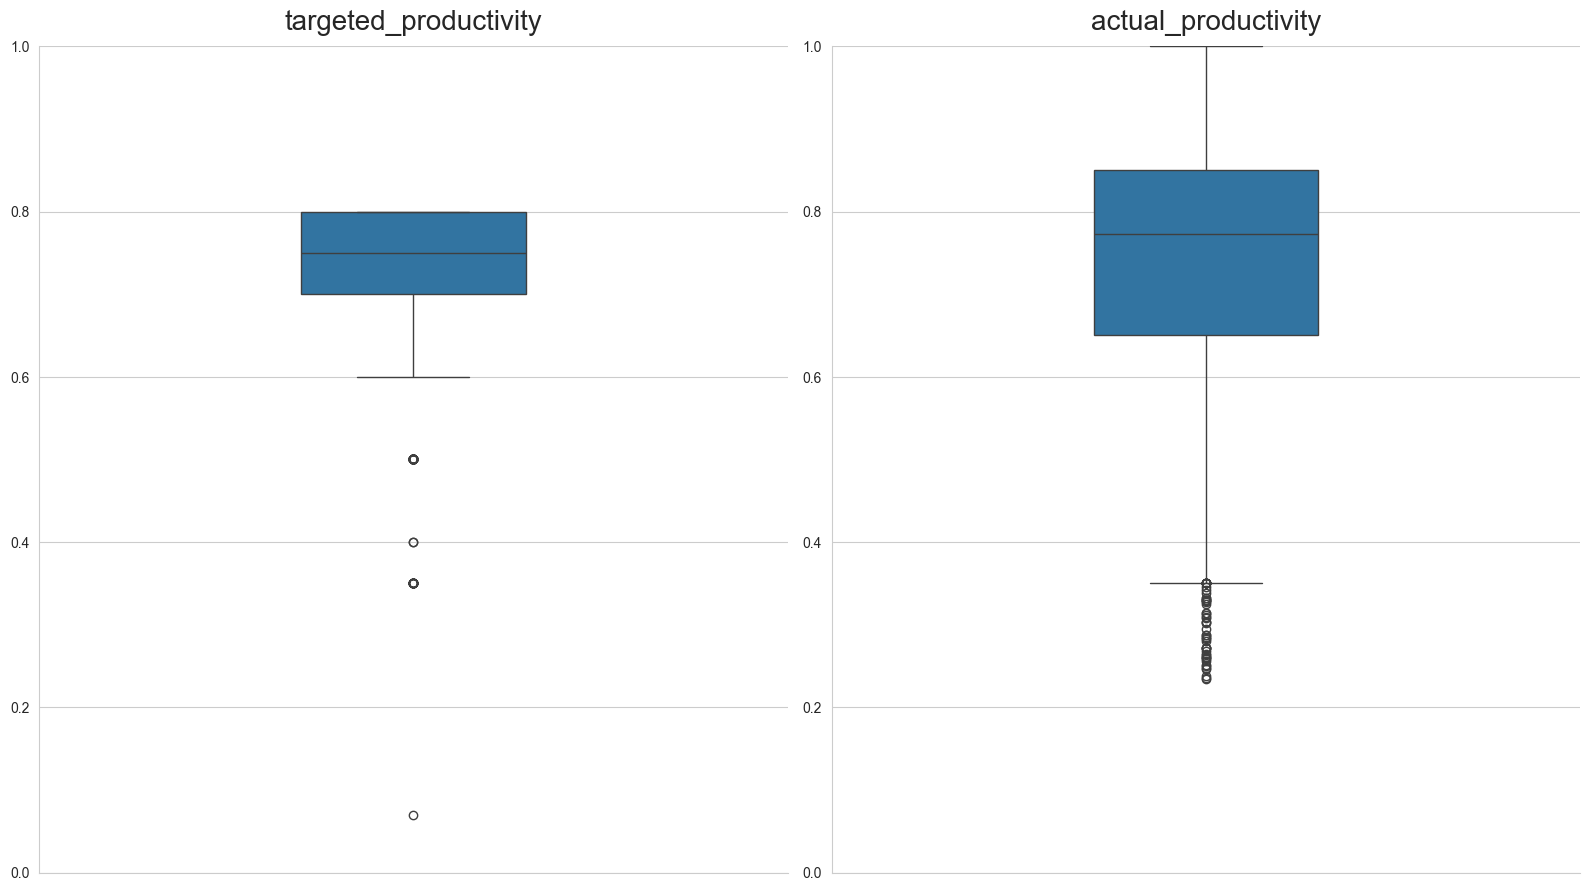

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))

for i, col in enumerate(['targeted_productivity', 'actual_productivity']):
    sns.boxplot(data=df, y=col, ax=axes[i], showfliers=True, width=0.3)
    axes[i].set_ylim(0, 1)
    axes[i].set_title(col, fontsize=20, y=1.01)
    axes[i].set_ylabel('')


plt.tight_layout()
sns.despine()
plt.show()

Seeing our plot, we could simply create categories based on final productivity values (e.g. Poor, Good, Excellent). Alternatively, we could classify our observations as either: exceeding targets or missing targets.

We will perform our second idea as this creates a simple binary classification.

In [125]:
# Create category based on actual_productivity > target_productivity or not.

df['exceeds_target'] = np.where(df['actual_productivity'] >= df['targeted_productivity'], 1, 0)

In [126]:
df.sample(5, random_state=42)

,department_sewing,quarter,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,exceeds_target
921,1.0,4.0,3.0,1.0,0.6,22.53,708.0,5040.0,0.0,0.0,0.0,1.0,42.0,0.268214,0
321,1.0,3.0,2.0,6.0,0.8,11.41,1028.0,4380.0,50.0,0.0,0.0,0.0,31.0,0.800359,1
101,0.0,1.0,3.0,8.0,0.8,2.90,0.0,1440.0,0.0,0.0,0.0,0.0,8.0,0.681061,0
920,0.0,4.0,3.0,2.0,0.7,3.90,0.0,960.0,0.0,0.0,0.0,0.0,8.0,0.325000,0
58,0.0,1.0,1.0,7.0,0.8,2.90,0.0,960.0,0.0,0.0,0.0,0.0,8.0,0.667604,0


In [127]:
# Create copy for model building (to preserve original columns in df)

df_copy = df.copy()

In [128]:
# Drop unnecessary columns in copied df

df_copy.drop(columns=['targeted_productivity', 'actual_productivity'], inplace=True)

### Visualizing Target Distribution

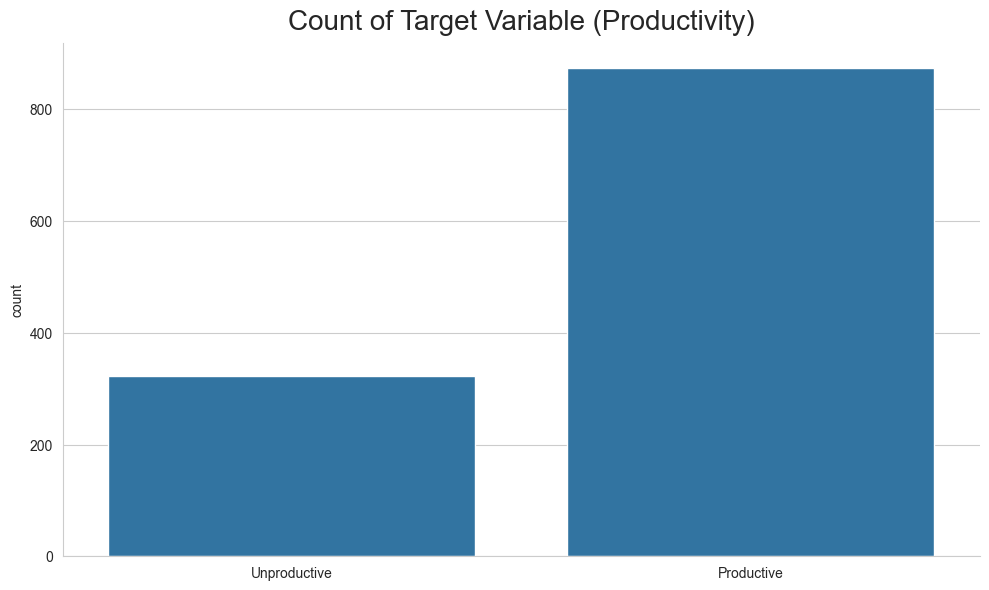

In [268]:
sns.countplot(data=df, x='exceeds_target')
plt.title('Count of Target Variable (Productivity)', fontsize=20, y=1.01)

plt.xticks([0, 1], ['Unproductive', 'Productive'])
plt.xlabel('')

plt.tight_layout()
sns.despine()
plt.show()

In [276]:
df_copy['exceeds_target'].value_counts(normalize=True)


exceeds_target
1    0.730994
0    0.269006
Name: proportion, dtype: float64

Now we can work on building our model, as well as playing around with which features we want to use.

## Model Building (Tree)

### Create Feature and Target Variables

In [129]:
X = df_copy.drop(columns=['exceeds_target'])
y = df['exceeds_target']

### Split Data

In [130]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

### Instantiate Tree Classifier and Find Optimal `ccp_alpha`

Lets choose not to set a `max_depth`, but use an optimal `ccp_alpha` to prune the tree.

In [131]:
from sklearn.tree import DecisionTreeClassifier

In [132]:
cost_tree = DecisionTreeClassifier(random_state=42)
cost_path = cost_tree.cost_complexity_pruning_path(X_train, y_train)

In [133]:
subtrees = []

for alpha in cost_path.ccp_alphas:
    subtree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    subtree.fit(X_train, y_train)
    subtrees.append(subtree)

In [134]:
ccp_alphas_slice = cost_path.ccp_alphas
subtrees_slice = subtrees

In [135]:
subtree_scores = [subtree.score(X_test, y_test) for subtree in subtrees_slice]

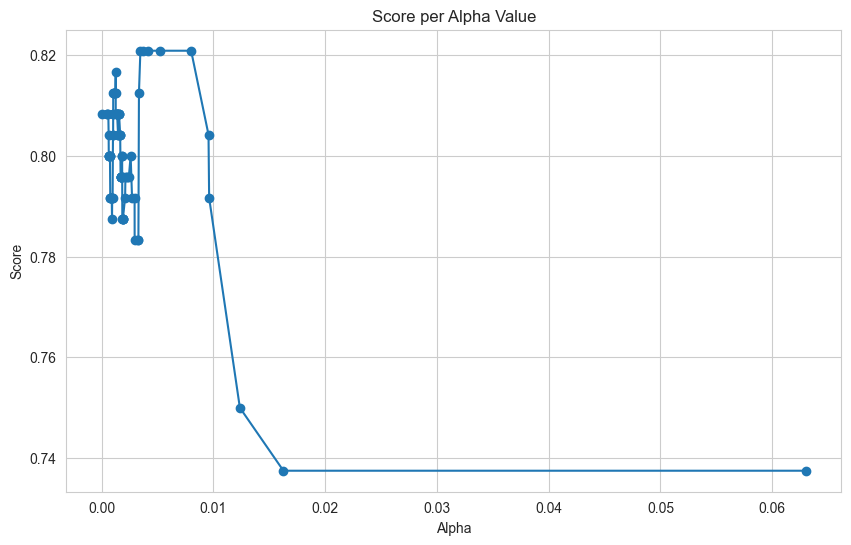

In [136]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10.0, 6.0]

fig, ax = plt.subplots()
ax.set_xlabel("Alpha")
ax.set_ylabel("Score")
ax.set_title("Score per Alpha Value")
ax.plot(ccp_alphas_slice, subtree_scores, marker="o")
plt.show()

We can see that our optimal ccp_alpha value lies between 0.003 and 0.008. Let's verify the exact value.

In [137]:
alpha_scores = tuple(zip(ccp_alphas_slice, subtree_scores))
print(max(alpha_scores, key=lambda x:x[1]))

(np.float64(0.0034796959482513642), 0.8208333333333333)


Based on our results, we can create our tree with a `ccp_alpha` of **0.00348**

## Model Building With Optimal `ccp_alpha`

In [138]:
optimal_ccp_alpha = max(alpha_scores, key=lambda x:x[1])[0]

In [139]:
tree = DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_ccp_alpha)

In [140]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=np.float64(0.0034796959482513642),
                       random_state=42)

In [141]:
tree.score(X_test, y_test)

0.8208333333333333

In [142]:
y_pred = tree.predict(X_test)

In [143]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.73      0.68        63
           1       0.90      0.85      0.88       177

    accuracy                           0.82       240
   macro avg       0.77      0.79      0.78       240
weighted avg       0.83      0.82      0.82       240

[[ 46  17]
 [ 26 151]]


### Cross-Validation

Lets get our cross-validation score to verify whether our model will work with varying folds of test data.

In [144]:
from sklearn.model_selection import cross_val_score

In [145]:
tree = DecisionTreeClassifier(random_state=42)
print(cross_val_score(tree, X, y, cv=5).mean())

0.7025174337517435


In [146]:
tree = DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_ccp_alpha)
print(cross_val_score(tree, X, y, cv=5).mean())

0.7835878661087865


We can see that our optimal `ccp_alpha` parameter value, with the pruning it provided, allowed our model to achieve an 8% higher accuracy result in classifying our data.

## Model Building with `GridSearchCV`

Let's try creating a model with a grid search and seeing whether we yield more accurate results with the best parameters.

In [147]:
from sklearn.model_selection import GridSearchCV

In [148]:
params = {
    'ccp_alpha': [0.0034796959482513642, 0],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7]
}

In [149]:
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=params, cv=5, n_jobs=-1)

In [150]:
grid.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0034796959482513642, 0],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10]})

In [151]:
best_params = grid.best_params_
best_score = grid.best_score_
print('Best params:\n',best_params, f'\n\nwith score: ', best_score)

Best params:
 {'ccp_alpha': 0.0034796959482513642, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2} 

with score:  0.789410739191074


In [152]:
best_estimator = grid.best_estimator_

In [153]:
best_estimator.score(X_test, y_test)

0.8333333333333334

In [154]:
y_pred = best_estimator.predict(X_test)

In [155]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.65      0.67        63
           1       0.88      0.90      0.89       177

    accuracy                           0.83       240
   macro avg       0.79      0.77      0.78       240
weighted avg       0.83      0.83      0.83       240

[[ 41  22]
 [ 18 159]]


With our grid search and optimal parameter findings, we achieve a higher cross-validated mean score on our overall data, as well as a slightly higher score on our testing data. However, we can see that our model is more precise in predicting true values rather than false.

### Visualize Tree

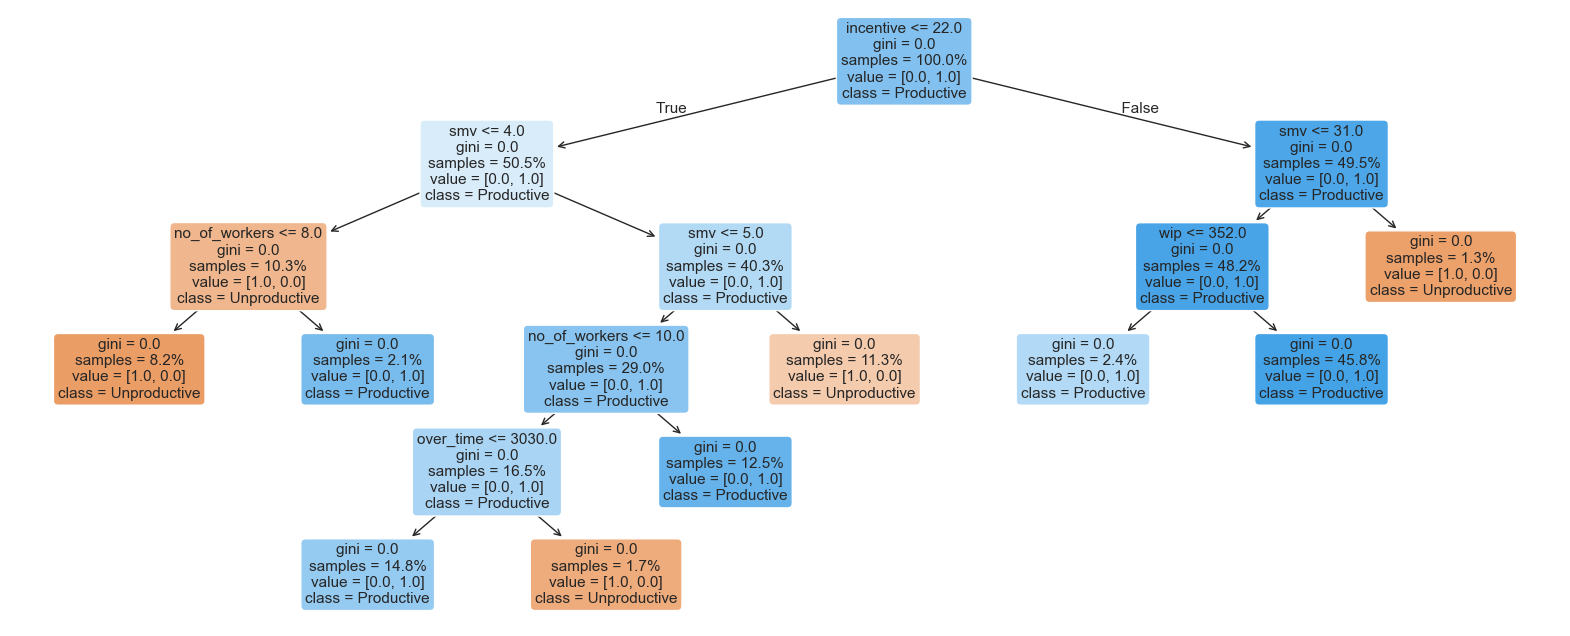

In [159]:
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

plt.figure(figsize = [20.0, 8.0]) # Setting the size of displayed Tree

plot_tree(best_estimator,
    feature_names=list(X.columns),
    class_names=['Unproductive', 'Productive'],
    filled=True,
    proportion=True,
    precision=0,
    rounded=True,
    fontsize=11)

plt.show()

Our tree modeling highlights the importance of features like `incentive`, `smv`, `no_of_workers`, `wip`, and `over_time`. These features appear at the top of various nodes (boxes), showing their role in predicting productivity.

To interpret the tree, start with the root node (the top box) and move downwards. Each node represents a decision point—a question that splits the data into two groups. For example, the root node asks, *"Is the incentive given to workers less than or equal to 22.0?"*

1. **The decision point (variable being split):**  
   - In simple terms, this is the question or condition we are using to divide the data into two groups.  
   - For example, here we are asking, *"Is the incentive given to workers less than or equal to 22.0?"*

2. **Gini Index:**  
   - This measures how "pure" or "mixed" the groups are after the split.  
   - In other words, it tells us how well this question (split) separates productive workers from unproductive ones. A Gini Index of 0 means the split is perfect—each group has only one class (all productive or all unproductive workers).

3. **Samples:**  
   - This is the total number of cases (or workers) at this point in the decision process.  
   - In other words, it shows how many workers we are analyzing at this stage before splitting them into groups.

4. **Value:**  
   - These numbers represent how many workers fall into each class (e.g., [Unproductive, Productive]).  
   - In other words, it shows how many workers are classified as productive and unproductive before we apply the split.

5. **Class:**  
   - This is the predominant category (or prediction) at this point.  
   - In other words, based on the data, most workers here are classified as either "Productive" or "Unproductive."

The tree continues splitting left (`True`) or right (`False`) at each node, repeating the pattern until the final nodes, where no further splits are possible.

Now, let's revisit the columns used in the model. `Incentive` refers to financial motivation (e.g., higher pay often correlates with better work). `SMV` (standard minute value) reflects allocated task time, with lower values potentially indicating greater productivity. Other features include `no_of_workers` (team size), `wip` (work in progress), and `over_time` (overtime minutes). Together, these features shaped our predictions of productivity.

Now lets try with a random forest.

## Model Building (Random Forest)

In [189]:
from sklearn.ensemble import RandomForestClassifier

In [222]:
random_forest = RandomForestClassifier(random_state=42, oob_score=True, bootstrap=True, n_jobs=-1)

In [223]:
random_forest.fit(X, y)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [224]:
random_forest.oob_score_

0.8203842940685045

In [225]:
y_pred = random_forest.predict(X_test)

In [226]:
from sklearn.metrics import accuracy_score

oob_predictions = random_forest.oob_decision_function_
classes = random_forest.classes_

oob_clf = pd.DataFrame(oob_predictions, columns = classes)
oob_clf["y_pred"] = oob_clf.idxmax(axis=1) # Get highest predicted probability
oob_clf["y_test"] = y # Get true classification

oob_accuracy = accuracy_score(oob_clf["y_test"], oob_clf["y_pred"])
print(oob_accuracy)

0.8203842940685045


In [227]:
print(classification_report(oob_clf["y_test"], oob_clf["y_pred"]))
print(confusion_matrix(oob_clf["y_test"], oob_clf["y_pred"]))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65       322
           1       0.87      0.89      0.88       875

    accuracy                           0.82      1197
   macro avg       0.77      0.76      0.77      1197
weighted avg       0.82      0.82      0.82      1197

[[201 121]
 [ 94 781]]


### With Grid Search

In [237]:
random_forest = RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1)

In [238]:
params = {
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5, 10],
    'max_depth': [None, 3, 5, 7],
    'n_estimators': [80, 100]
}

In [239]:
grid_random_class = GridSearchCV(random_forest, param_grid=params, n_jobs=-1)

In [240]:
grid_random_class.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 3, 5, 7],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [80, 100]})

In [241]:
best_params = grid_random_class.best_params_
best_score = grid_random_class.best_score_
print('Best params:\n',best_params, f'\n\nwith score: ', best_score)

Best params:
 {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 80} 

with score:  0.7869595536959555


In [242]:
best_estimator = grid_random_class.best_estimator_

In [247]:
best_estimator.oob_score_

0.7861319966583125

In [244]:
y_pred = best_estimator.predict(X_test)

In [245]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.27      0.40        63
           1       0.79      0.97      0.87       177

    accuracy                           0.79       240
   macro avg       0.78      0.62      0.64       240
weighted avg       0.78      0.79      0.75       240

[[ 17  46]
 [  5 172]]


## Model Building (XGBoost)

This workflow helps to find the optimal `num_boost_round` with early stopping, using the `cv()` method, then instantiates a model to train on.

In [250]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)

params = {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'eta': 0.1, 'max_depth': 6}
cv_results = xgb.cv(params, dtrain, num_boost_round=100, nfold=5, early_stopping_rounds=10, metrics='logloss')

best_round = len(cv_results)
xgb_model = xgb.train(params, dtrain, num_boost_round=best_round)

In [261]:
from sklearn.metrics import accuracy_score

y_pred = xgb_model.predict(xgb.DMatrix(X_test))
accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))
accuracy

0.8291666666666667

In [262]:
print(classification_report(y_test, (y_pred > 0.5).astype(int)))
print(confusion_matrix(y_test, (y_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.72      0.57      0.64        63
           1       0.86      0.92      0.89       177

    accuracy                           0.83       240
   macro avg       0.79      0.75      0.76       240
weighted avg       0.82      0.83      0.82       240

[[ 36  27]
 [ 14 163]]
